[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/chatbot-external-memory.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239440-lesson-6-chatbot-w-summarizing-messages-and-external-memory)

# Chatbot with message summarization & external DB memory

## Review

We've covered how to customize graph state schema and reducer. 
 
We've also shown a number of tricks for trimming or filtering messages in graph state. 

We've used these concepts in a Chatbot with memory that produces a running summary of the conversation.

## Goals

But, what if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some more advanced checkpointers that support external databases. 

Here, we'll show how to use [Sqlite as a checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer), but other checkpointers, such as [Postgres](https://langchain-ai.github.io/langgraph/how-tos/persistence_postgres/) are available!

In [5]:
%%capture --no-stderr
%pip install --quiet -U langgraph-checkpoint-sqlite langchain_core langgraph langchain_openai

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

## Sqlite

A good starting point here is the [SqliteSaver checkpointer](https://langchain-ai.github.io/langgraph/concepts/low_level/#checkpointer).

Sqlite is a [small, fast, highly popular](https://x.com/karpathy/status/1819490455664685297) SQL database. 
 
If we supply `":memory:"` it creates an in-memory Sqlite database.

In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

But, if we supply a db path, then it will create a database for us!

In [3]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file state_db already exists.
Error occurred while processing: state_db.


In [4]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

Let's re-define our chatbot.

In [5]:
from typing import Literal

from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatOpenAI(model="gpt-4.1-nano",temperature=0)

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal["summarize_conversation", END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

Now, we just re-compile with our sqlite checkpointer.

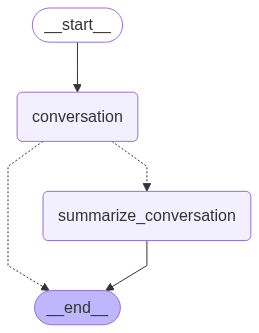

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times. 

In [9]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Lance")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like the 49ers!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello again, Lance! It's great to hear from you. Is there something specific you'd like to chat about today? Maybe more about the 49ers or something else you're interested in?
================================== Ai Message ==================================

Your name is Lance. Nice to meet you again! How can I assist you today?
================================== Ai Message ==================================

That's awesome, Lance! The 49ers are a fantastic team with a rich history. Do you have a favorite player or a memorable game you'd like to talk about?


Let's confirm that our state is saved locally.

In [10]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='a31fd6d6-ccb1-41f5-9cc4-52447ddabd26'), AIMessage(content="Hello again, Lance! It's great to hear from you. Is there something specific you'd like to chat about today? Maybe more about the 49ers or something else you're interested in?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 337, 'total_tokens': 374, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzWoqbSJ4ducbuhPY6eaiOxBCPboC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e3e4e1f-a9ca-4c62-b821-7b39b9ea0d7d-0', usage_metadata={'input_tokens': 337, 'output_to

### Persisting state

Using database like Sqlite means state is persisted! 

For example, we can re-start the notebook kernel and see that we can still load from Sqlite DB on disk.


In [7]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='a31fd6d6-ccb1-41f5-9cc4-52447ddabd26'), AIMessage(content="Hello again, Lance! It's great to hear from you. Is there something specific you'd like to chat about today? Maybe more about the 49ers or something else you're interested in?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 337, 'total_tokens': 374, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzWoqbSJ4ducbuhPY6eaiOxBCPboC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e3e4e1f-a9ca-4c62-b821-7b39b9ea0d7d-0', usage_metadata={'input_tokens': 337, 'output_to

### Time Travel & Branching Conversation (Self-study)

In [8]:
checkpoints = list(graph.get_state_history(config))
for i, checkpoint in enumerate(checkpoints):
    print(f"Checkpoint {i}: {checkpoint.values}")

Checkpoint 0: {'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='a31fd6d6-ccb1-41f5-9cc4-52447ddabd26'), AIMessage(content="Hello again, Lance! It's great to hear from you. Is there something specific you'd like to chat about today? Maybe more about the 49ers or something else you're interested in?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 337, 'total_tokens': 374, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzWoqbSJ4ducbuhPY6eaiOxBCPboC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e3e4e1f-a9ca-4c62-b821-7b39b9ea0d7d-0', usage_metadata={'input_tokens': 337, 'output_tokens': 

In [ ]:
config = {"configurable": {"thread_id": "1"}}

# Check all checkpoint history
for i, checkpoint in enumerate(graph.get_state_history(config)):
    print(f"Checkpoint {i}:")
    print(f"  Messages count: {len(checkpoint.values.get('messages', []))}")
    print(f"  Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}")
    print()

Checkpoint 0:
  Messages count: 6
  Checkpoint ID: 1f06e649-4793-6ef9-801b-abb44566e26c

Checkpoint 1:
  Messages count: 5
  Checkpoint ID: 1f06e649-3d2d-64dc-801a-b53018e2f5bc

Checkpoint 2:
  Messages count: 4
  Checkpoint ID: 1f06e649-3d28-66a2-8019-eb31d88036ce

Checkpoint 3:
  Messages count: 4
  Checkpoint ID: 1f06e649-3d15-63a9-8018-90859dc12ff8

Checkpoint 4:
  Messages count: 3
  Checkpoint ID: 1f06e649-3650-6401-8017-fb85a9c49bae

Checkpoint 5:
  Messages count: 2
  Checkpoint ID: 1f06e649-364a-6b9e-8016-11d20307a568

Checkpoint 6:
  Messages count: 2
  Checkpoint ID: 1f06e649-362e-6315-8015-bee174676fc3

Checkpoint 7:
  Messages count: 8
  Checkpoint ID: 1f06e649-121d-6b18-8014-7082daf61724

Checkpoint 8:
  Messages count: 7
  Checkpoint ID: 1f06e649-0513-6428-8013-a6f013c95b81

Checkpoint 9:
  Messages count: 6
  Checkpoint ID: 1f06e649-0509-679d-8012-394f27aec64d

Checkpoint 10:
  Messages count: 6
  Checkpoint ID: 1ef64b23-31cd-655a-8011-d28d83f59223

Checkpoint 11:
  Mes

In [ ]:
# 1. Check checkpoint.values
checkpoint = graph.get_state(config)
print("Full state:", checkpoint.values)
print("Message count:", len(checkpoint.values.get('messages', [])))

# 2. Direct check of writes table (SQLite)
import sqlite3
conn = sqlite3.connect('state_db/example.db')
cursor = conn.cursor()

cursor.execute("""
    SELECT task_id, channel, value 
    FROM writes 
    WHERE thread_id = '1' 
    ORDER BY checkpoint_id
""")
results = cursor.fetchall()
for task_id, channel, value in results:
    print(f"Node: {task_id}, Channel: {channel}, Value: {value[:100]}...")

전체 상태: {'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='a31fd6d6-ccb1-41f5-9cc4-52447ddabd26'), AIMessage(content="Hello again, Lance! It's great to hear from you. Is there something specific you'd like to chat about today? Maybe more about the 49ers or something else you're interested in?", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 37, 'prompt_tokens': 337, 'total_tokens': 374, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzWoqbSJ4ducbuhPY6eaiOxBCPboC', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1e3e4e1f-a9ca-4c62-b821-7b39b9ea0d7d-0', usage_metadata={'input_tokens': 337, 'output_tokens': 37, 'to

In [16]:
# continue conversation
input_message = HumanMessage(content="hi! I'm Lance's friend, Daniel")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hi Daniel! Nice to meet you again. How can I assist you today?
================================== Ai Message ==================================

Your name is Daniel. Nice to meet you!


In [17]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance's friend, Daniel", additional_kwargs={}, response_metadata={}, id='3a31955c-58ba-465b-a9a9-4dca065d704c'), AIMessage(content='Hi Daniel! Nice to meet you again. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 361, 'total_tokens': 377, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzXufE3HNTSOXmDFN5HIMuk4okrRJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--218e0ea1-8cac-4f89-aa57-6f8e5bb389e6-0', usage_metadata={'input_tokens': 361, 'output_tokens': 16, 'total_tokens': 377, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_to

In [ ]:
config = {"configurable": {"thread_id": "1"}}

# Check all checkpoint history
for i, checkpoint in enumerate(graph.get_state_history(config)):
    print(f"Checkpoint {i}:")
    print(f"  Messages count: {len(checkpoint.values.get('messages', []))}")
    print(f"  Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}")
    print()

Checkpoint 0:
  Messages count: 4
  Checkpoint ID: 1f06e6e5-cdb5-6238-8036-79c52b2ad754

Checkpoint 1:
  Messages count: 3
  Checkpoint ID: 1f06e6e5-c8d7-609e-8035-5a51d449568f

Checkpoint 2:
  Messages count: 2
  Checkpoint ID: 1f06e6e5-c8cf-64e1-8034-c6b218d20634

Checkpoint 3:
  Messages count: 2
  Checkpoint ID: 1f06e6e5-c8b3-65a0-8033-10514e06c4b3

Checkpoint 4:
  Messages count: 8
  Checkpoint ID: 1f06e6e5-b2dd-6104-8032-5c70fb8a5d35

Checkpoint 5:
  Messages count: 7
  Checkpoint ID: 1f06e6e5-ab21-6650-8031-59a3f31dfe0b

Checkpoint 6:
  Messages count: 6
  Checkpoint ID: 1f06e6e5-ab1c-67e3-8030-950b1c34c5ba

Checkpoint 7:
  Messages count: 6
  Checkpoint ID: 1f06e6e2-c3bc-6a54-802f-0b71889f29fc

Checkpoint 8:
  Messages count: 5
  Checkpoint ID: 1f06e6e2-ba67-68e9-802e-ed928ac948a2

Checkpoint 9:
  Messages count: 4
  Checkpoint ID: 1f06e6e2-ba62-6ad0-802d-2b900b14e214

Checkpoint 10:
  Messages count: 4
  Checkpoint ID: 1f06e6e2-ba4c-6541-802c-fcf7f0b82d25

Checkpoint 11:
  Mes

In [ ]:
# 1. Check checkpoint.values
checkpoint = graph.get_state(config)
print("Full state:", checkpoint.values)
print("Message count:", len(checkpoint.values.get('messages', [])))

# 2. Direct check of writes table (SQLite)
import sqlite3
conn = sqlite3.connect('state_db/example.db')
cursor = conn.cursor()

cursor.execute("""
    SELECT task_id, channel, value 
    FROM writes 
    WHERE thread_id = '1' 
    ORDER BY checkpoint_id
""")
results = cursor.fetchall()
for task_id, channel, value in results:
    print(f"Node: {task_id}, Channel: {channel}, Value: {value[:100]}...")

전체 상태: {'messages': [HumanMessage(content="hi! I'm Lance's friend, Daniel", additional_kwargs={}, response_metadata={}, id='3a31955c-58ba-465b-a9a9-4dca065d704c'), AIMessage(content='Hi Daniel! Nice to meet you again. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 361, 'total_tokens': 377, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzXufE3HNTSOXmDFN5HIMuk4okrRJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--218e0ea1-8cac-4f89-aa57-6f8e5bb389e6-0', usage_metadata={'input_tokens': 361, 'output_tokens': 16, 'total_tokens': 377, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': 

In [ ]:
config = {"configurable": {"thread_id": "1"}}

# Check all checkpoint history
checkpoints = list(graph.get_state_history(config))
for i, checkpoint in enumerate(checkpoints):
    print(f"Checkpoint {i}:")
    print(f"  Messages count: {len(checkpoint.values.get('messages', []))}")
    print(f"  Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}")
    print(f"  Summary: {checkpoint.values.get('summary', 'No summary')[:50]}...")
    print()

Checkpoint 0:
  Messages count: 4
  Checkpoint ID: 1f06e6e5-cdb5-6238-8036-79c52b2ad754
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 1:
  Messages count: 3
  Checkpoint ID: 1f06e6e5-c8d7-609e-8035-5a51d449568f
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 2:
  Messages count: 2
  Checkpoint ID: 1f06e6e5-c8cf-64e1-8034-c6b218d20634
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 3:
  Messages count: 2
  Checkpoint ID: 1f06e6e5-c8b3-65a0-8033-10514e06c4b3
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 4:
  Messages count: 8
  Checkpoint ID: 1f06e6e5-b2dd-6104-8032-5c70fb8a5d35
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 5:
  Messages count: 7
  Checkpoint ID: 1f06e6e5-ab21-6650-8031-59a3f31dfe0b
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 6:
  Messages count: 6
  Checkpoint ID: 1f06e6e5-ab1c-67e3-8030-9

In [ ]:
# Example: Go back to the point when talking with Lance
target_checkpoint_id = "1f06e649-121d-6b18-8014-7082daf61724"  # Point with 8 messages

# Config to go back to that checkpoint
time_travel_config = {
    "configurable": {
        "thread_id": "1",
        "checkpoint_id": target_checkpoint_id  # Key!
    }
}

# Check the state at that point
past_state = graph.get_state(time_travel_config)
print("Past state:", past_state.values)

# Start a new conversation from that point in the past
input_message = HumanMessage(content="Actually, let's talk about something else. Could you write a poem with my name?")
output = graph.invoke({"messages": [input_message]}, time_travel_config)

# A new branch is created!
for m in output['messages'][-1:]:
    m.pretty_print()

# Original Timeline:
# Lance conversation → Daniel conversation → Current

# After Time Travel:
# Lance conversation → New branch → Different conversation
#                   ↘ Daniel conversation → Current (preserved)

과거 상태: {'messages': [HumanMessage(content="hi! I'm Lance", additional_kwargs={}, response_metadata={}, id='086e80ce-8bd0-4dee-b13c-f47160d6755f'), AIMessage(content="Hello Lance! You've already introduced yourself, but it's nice to greet you again. Is there something specific you'd like to talk about? Perhaps you'd like to continue our conversation about the 49ers, or is there another topic you're interested in discussing?", additional_kwargs={}, response_metadata={'id': 'msg_01AkDF6AH7LMp2YDDD9jQkEC', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 197, 'output_tokens': 58}}, id='run-7f8af5e1-5248-4ccd-ab46-87580422f0d6-0', usage_metadata={'input_tokens': 197, 'output_tokens': 58, 'total_tokens': 255}), HumanMessage(content="what's my name?", additional_kwargs={}, response_metadata={}, id='e33f42ee-cdb0-45ec-b100-54dcd4c82e71'), AIMessage(content="Your name is Lance. You've introduced yourself twice during our conversa

In [ ]:
config = {"configurable": {"thread_id": "1"}}

# Check all checkpoint history (latest is 0)
checkpoints = list(graph.get_state_history(config))
for i, checkpoint in enumerate(checkpoints):
    print(f"Checkpoint {i}:")
    print(f"  Messages count: {len(checkpoint.values.get('messages', []))}")
    print(f"  Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}")
    print(f"  Summary: {checkpoint.values.get('summary', 'No summary')[:50]}...")
    print()


Checkpoint 0:
  Messages count: 2
  Checkpoint ID: 1f06e70b-2cbb-6767-8018-2d46327f6ab4
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 1:
  Messages count: 10
  Checkpoint ID: 1f06e70b-1521-69e9-8017-82f7d64b96ec
  Summary: Here's a summary of the conversation:

Lance intro...

Checkpoint 2:
  Messages count: 9
  Checkpoint ID: 1f06e70b-067b-664a-8016-54b3162a7114
  Summary: Here's a summary of the conversation:

Lance intro...

Checkpoint 3:
  Messages count: 8
  Checkpoint ID: 1f06e70b-0674-60e6-8015-9ccd6f724011
  Summary: Here's a summary of the conversation:

Lance intro...

Checkpoint 4:
  Messages count: 4
  Checkpoint ID: 1f06e6e5-cdb5-6238-8036-79c52b2ad754
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 5:
  Messages count: 3
  Checkpoint ID: 1f06e6e5-c8d7-609e-8035-5a51d449568f
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 6:
  Messages count: 2
  Checkpoint ID: 1f06e6e5-c8cf-64e1-8034-

In [ ]:

# Select desired checkpoint (example: point when talking with Lance)
to_replay = checkpoints[7]  # Point with 8 messages
print(to_replay.config)

# Re-run from that checkpoint
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06e6e5-c8b3-65a0-8033-10514e06c4b3'}}
================================== Ai Message ==================================

Hi Daniel! Nice to meet you again. How can I assist you today?


In [ ]:
# Step 1: Select checkpoint to go back to
to_fork = checkpoints[7]  # Point when talking with Lance

# Step 2: Update state with new message
fork_config = graph.update_state(
    to_fork.config,
    {"messages": [HumanMessage(content="Let's talk about basketball instead!", 
                               id=to_fork.values["messages"][-1].id)]},  # Overwrite last message
)

# Step 3: Start conversation in new branch
for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Let's talk about basketball instead!


In [ ]:
# 1. (example: checkpoint 7)
daniel_checkpoint = checkpoints[7]
print(daniel_checkpoint.config)
print("Messages at Daniel's point:", daniel_checkpoint.values['messages'])

# 2. Start new conversation from that point
new_message = HumanMessage(content="Actually, let's talk about the Lakers!")
fork_config = graph.update_state(
    daniel_checkpoint.config,
    {"messages": [new_message]}  # Add new message
)

# 3. Start talking about Lakers in conversation context!
output = graph.invoke({"messages": []}, fork_config)

{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f06e6e5-c8b3-65a0-8033-10514e06c4b3'}}
Daniel 시점 메시지들: [HumanMessage(content="hi! I'm Lance's friend, Daniel", additional_kwargs={}, response_metadata={}, id='3a31955c-58ba-465b-a9a9-4dca065d704c'), AIMessage(content='Hi Daniel! Nice to meet you again. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 361, 'total_tokens': 377, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzXufE3HNTSOXmDFN5HIMuk4okrRJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--218e0ea1-8cac-4f89-aa57-6f8e5bb389e6-0', usage_metadata={'input_tokens': 361, 'output_t

In [29]:
output

{'messages': [HumanMessage(content="hi! I'm Lance's friend, Daniel", additional_kwargs={}, response_metadata={}, id='3a31955c-58ba-465b-a9a9-4dca065d704c'),
  AIMessage(content='Hi Daniel! Nice to meet you again. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 361, 'total_tokens': 377, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzXufE3HNTSOXmDFN5HIMuk4okrRJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--218e0ea1-8cac-4f89-aa57-6f8e5bb389e6-0', usage_metadata={'input_tokens': 361, 'output_tokens': 16, 'total_tokens': 377, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'aud

In [ ]:
config = {"configurable": {"thread_id": "1"}}

# Check all checkpoint history (latest is 0)
checkpoints = list(graph.get_state_history(config))
for i, checkpoint in enumerate(checkpoints):
    print(f"Checkpoint {i}:")
    print(f"  Messages count: {len(checkpoint.values.get('messages', []))}")
    print(f"  Checkpoint ID: {checkpoint.config['configurable']['checkpoint_id']}")
    print(f"  Summary: {checkpoint.values.get('summary', 'No summary')[:50]}...")
    print()

Checkpoint 0:
  Messages count: 4
  Checkpoint ID: 1f06e727-4e81-6753-8037-3e02f5d21fcd
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 1:
  Messages count: 3
  Checkpoint ID: 1f06e727-43d9-6209-8036-37c3b69d3b77
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 2:
  Messages count: 3
  Checkpoint ID: 1f06e727-43d1-6274-8035-1641206e2cac
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 3:
  Messages count: 3
  Checkpoint ID: 1f06e727-43c6-6c7b-8034-f016b3751d8e
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 4:
  Messages count: 4
  Checkpoint ID: 1f06e726-92cf-685b-8037-10e7e6434056
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 5:
  Messages count: 3
  Checkpoint ID: 1f06e726-8918-6690-8036-a902f17ebf2b
  Summary: Certainly! Here's an extended summary of our conve...

Checkpoint 6:
  Messages count: 3
  Checkpoint ID: 1f06e726-8911-61bf-8035-e

In [31]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Lance's friend, Daniel", additional_kwargs={}, response_metadata={}, id='3a31955c-58ba-465b-a9a9-4dca065d704c'), AIMessage(content='Hi Daniel! Nice to meet you again. How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 361, 'total_tokens': 377, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_38343a2f8f', 'id': 'chatcmpl-BzXufE3HNTSOXmDFN5HIMuk4okrRJ', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--218e0ea1-8cac-4f89-aa57-6f8e5bb389e6-0', usage_metadata={'input_tokens': 361, 'output_tokens': 16, 'total_tokens': 377, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_to

#### To rollback to the current checkpoint

In [ ]:
# 1. 🏷️ Save checkpoint_id before branching
# Backup current state before branching
current_state = graph.get_state(config)
daniel_checkpoint_id = current_state.config['configurable']['checkpoint_id']

# Return to Daniel conversation later
daniel_config = {
    "configurable": {
        "thread_id": "1",
        "checkpoint_id": daniel_checkpoint_id  # Use saved ID
    }
}
daniel_state = graph.get_state(daniel_config)

In [ ]:
# 2. 🗂️ Conversation Management Class w/ Bookmark
class ConversationManager:
    def __init__(self, graph, thread_id):
        self.graph = graph
        self.thread_id = thread_id
        self.bookmarks = {}  # Store conversation bookmarks
    
    def bookmark_current_state(self, bookmark_name):
        """Save current state as bookmark"""
        config = {"configurable": {"thread_id": self.thread_id}}
        current_state = self.graph.get_state(config)
        self.bookmarks[bookmark_name] = current_state.config['configurable']['checkpoint_id']
        return current_state
    
    def return_to_bookmark(self, bookmark_name):
        """Return to bookmarked conversation"""
        if bookmark_name not in self.bookmarks:
            raise ValueError(f"Bookmark '{bookmark_name}' not found")
        
        return {
            "configurable": {
                "thread_id": self.thread_id,
                "checkpoint_id": self.bookmarks[bookmark_name]
            }
        }
    
    def list_bookmarks(self):
        """List saved bookmarks"""
        return list(self.bookmarks.keys())

# Usage
cm = ConversationManager(graph, "1")

# While talking with Daniel
daniel_config = cm.bookmark_current_state("daniel_conversation")

# Branch to specific point
lance_checkpoint = checkpoints[7]
fork_config = graph.update_state(lance_checkpoint.config, {})

# Return to Daniel conversation later
back_to_daniel = cm.return_to_bookmark("daniel_conversation")
daniel_state = graph.get_state(back_to_daniel)

In [ ]:
# 2. 🏗️ Conversation Management Function: Practical Workflow
def safe_fork_conversation(graph, thread_id, target_checkpoint, new_input):
    """Safe branch creation (preserving original conversation path)"""
    
    # 1. Backup current state
    current_config = {"configurable": {"thread_id": thread_id}}
    current_state = graph.get_state(current_config)
    original_checkpoint_id = current_state.config['configurable']['checkpoint_id']
    
    print(f"💾 Original conversation backup: {original_checkpoint_id}")
    
    # 2. Create branch
    fork_config = graph.update_state(target_checkpoint.config, new_input)
    print(f"🌿 Branch created: {fork_config['configurable']['checkpoint_id']}")
    
    # 3. Return return information
    return {
        "fork_config": fork_config,
        "original_config": {
            "configurable": {
                "thread_id": thread_id,
                "checkpoint_id": original_checkpoint_id
            }
        }
    }

# Usage
result = safe_fork_conversation(
    graph, 
    "1", 
    lance_checkpoint, 
    {"messages": [HumanMessage("Let's talk about basketball!")]}
)

# Conversation in branch
graph.invoke({...}, result["fork_config"])

# Return to original
original_state = graph.get_state(result["original_config"])

## LangGraph Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.